# HIPPO for 2A Protease (6/?)

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from pathlib import Path
import molparse as mp
import hippo2 as hippo
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from pprint import pprint
import json
import mout
import pickle

## Load the project

In [3]:
# animal = hippo.HIPPO.from_pickle('pickles/2A_hippo_fingerprinted_trim.pickle')
animal = hippo.HIPPO.from_pickle('pickles/2A_hippo_fragnet_random_latest.pickle')

path = pickles/2A_hippo_fragnet_random_latest.pickle 


In [4]:
animal.bases

CompoundSet("bases", #compounds=17, #poses=0)

## Load the BBSs

In [5]:
bbs_dir = Path('bbs_fragnet_3k')

In [6]:
catalytic_poses = animal.get_poses('Catalytic', search=True, all_poses=animal.hits.poses)
print(catalytic_poses)
CATALYTIC_FEATURES = catalytic_poses.get_present_features()
N_CATALYTIC_FEATURES = len(CATALYTIC_FEATURES)

PoseSet(#poses=8, [0A, 0A, 0A, 0A, 0A, 0A, 0A, 0A])


In [7]:
def catalytic_features(bbs):
    features = bbs.products.get_present_features()
    return len([f for f in CATALYTIC_FEATURES if f in features])

def num_features(bbs):
    features = bbs.products.get_present_features()
    return len(features)

In [29]:
def num_bases(bbs):
    # print(bbs.products)
    return len(set([p.base.name for p in bbs.products if p.base is not None]))

def num_products(bbs):
    return len(bbs.products)

from collections import Counter
import numpy as np

def base_balance(bbs):
    bases = [p.base.name for p in bbs.products if p.base is not None]
    counter = Counter(bases)
    # for base in set(bases):
        # print(base, counter[base])
    return np.std([counter[base] for base in set(bases)])

In [30]:
base_balance(p)

15.627610892974724

In [31]:
pickles = bbs_dir.glob('BBS_???.pickle')
bb_sets = []
n=2000
for i,p in enumerate(pickles):
    # if i > 500:
        # break
    # if i%10 == 0:
        # mout.out(f'{i=}')
    mout.progress(i,n,append=f'{i=} {p.name}')
    p = pickle.load(open(p, 'rb'))

    d = dict(
        name=p.name,
        catalytic_features=catalytic_features(p),
        num_features=num_features(p),
        num_bases=num_bases(p),
        num_products=num_products(p),
        base_balance=base_balance(p),
    )
    
    bb_sets.append(d)

[######                      ]  24.95% i=499 BBS_ALJ.pickle

In [32]:
mout.interrupt()

[###             ]  24.95% i=499 BBS_ALJ.pickle INTERRUPTED


## Define the scorer

In [40]:
print('start')
scorer = hippo.scoring.Scorer(
    animal, 
    bb_sets, 
    ['num_products',
     'num_bases',
     'catalytic_features',
     'num_features',
     'base_balance',
    ])
    # ['num_products'])

# print('num_products')
# scorer.add_attribute(hippo.scoring.CustomAttribute('num_products', bb_sets, num_products))
# print('num_bases')
# scorer.add_attribute(hippo.scoring.CustomAttribute('num_bases', bb_sets, num_bases))
# print('catalytic_features')
# scorer.add_attribute(hippo.scoring.CustomAttribute('catalytic_features', bb_sets, catalytic_features))
# print('num_features')
# scorer.add_attribute(hippo.scoring.CustomAttribute('num_features', bb_sets, num_features))

scorer.weights = [1.0, 1.0, 1.0, 1.0, -1.0]

start
>>> Scorer(HIPPO(hippo2_test))         
>>> Getting values for Attribute(num_products)...
>>> Getting values for Attribute(num_bases)...
>>> Getting values for Attribute(catalytic_features)...
>>> Getting values for Attribute(num_features)...
>>> Getting values for Attribute(base_balance)...


In [41]:
top = scorer.top(5)

>>> sorting 500 BB sets...             


In [42]:
for bbs in top:
    mout.header(bbs['name'])
    scorer.score(bbs, verbosity=1)

BBS_ABK                                         
                  key  weight       value          unweighted  weighted
0        num_products     0.2   79.000000  0.6324102564102566  0.126482
1           num_bases     0.2   13.000000  0.9610000000000001  0.192200
2  catalytic_features     0.2   52.000000  0.9159999999999999  0.183200
3        num_features     0.2  146.000000  0.9796923076923081  0.195938
4        base_balance     0.2    5.497713            0.898699  0.179740
score = 0.87756024                
BBS_ARQ                                         
                  key  weight       value          unweighted  weighted
0        num_products     0.2   85.000000  0.7698461538461538  0.153969
1           num_bases     0.2   13.000000  0.9610000000000001  0.192200
2  catalytic_features     0.2   52.000000  0.9159999999999999  0.183200
3        num_features     0.2  139.000000  0.9080000000000003  0.181600
4        base_balance     0.2    6.440442            0.807096  0.161419
sco

## Plotting

In [43]:
label=[bbs['name'] for bbs in top]

plot_data = []
for bbs in bb_sets:
    d = dict(
        name=bbs['name'],
        score=scorer(bbs),
        label = bbs['name'] if bbs['name'] in label else '',
    )

    for attribute in scorer.attributes:
        d[attribute.key] = attribute.get_value(bbs)

    plot_data.append(d)

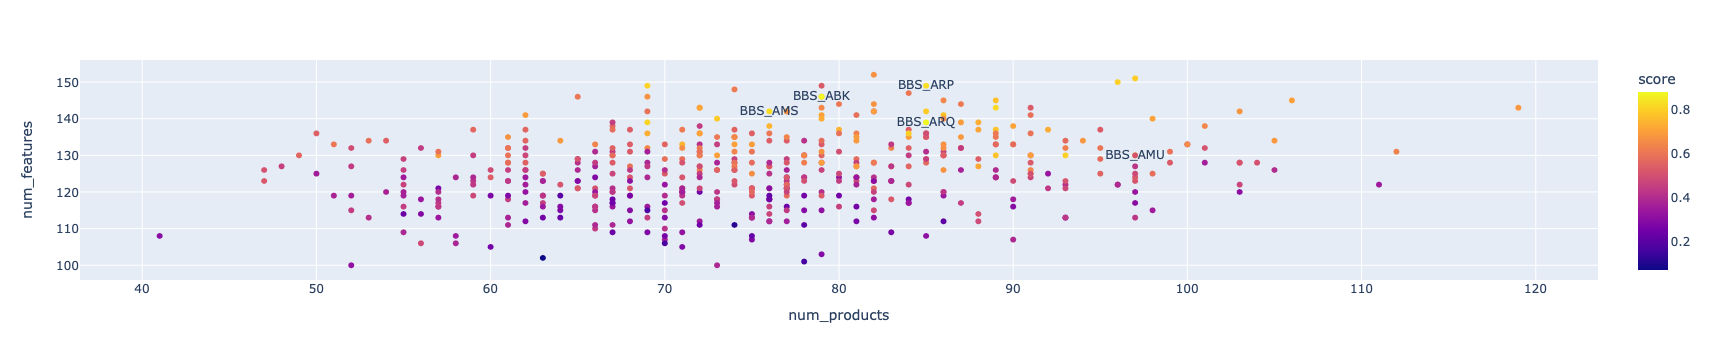

In [44]:
px.scatter(plot_data, x='num_products', y='num_features', color='score', hover_data=plot_data[0].keys(), text='label')

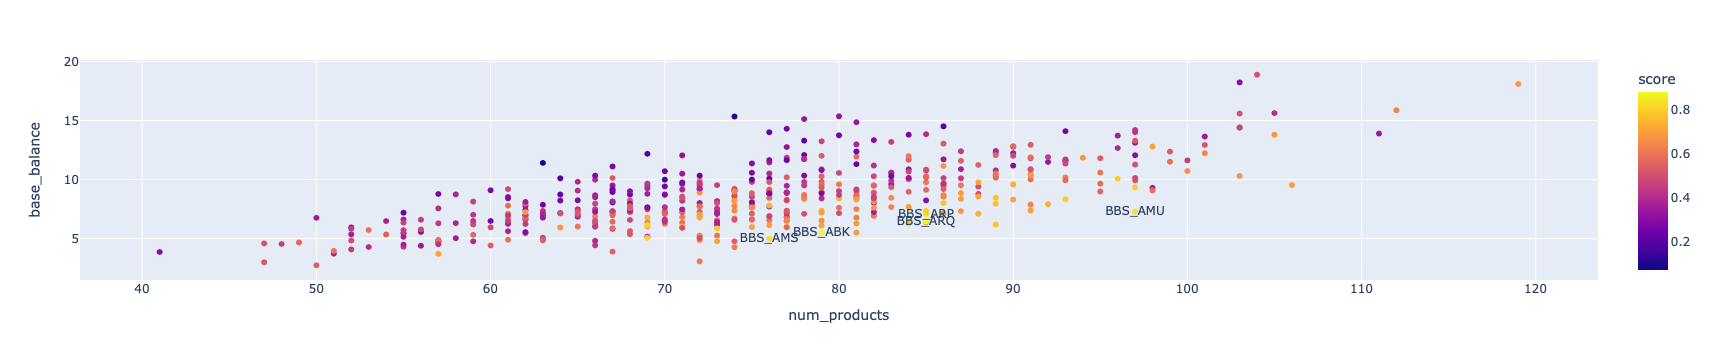

In [45]:
px.scatter(plot_data, x='num_products', y='base_balance', color='score', hover_data=plot_data[0].keys(), text='label')

## Write CSV

In [43]:
chosen = top[0]
chosen = pickle.load(open(bbs_dir/f'{chosen["name"]}.pickle', 'rb'))

In [36]:
chosen = pickle.load(open(bbs_dir/f'BBS_AIN.pickle', 'rb'))

In [49]:
chosen.name

'BBS_ADH'

In [44]:
for bb in chosen:
    bb.__num_reactions = 0
    
for comp in chosen.products:
    # print(comp.reaction)
    for bb in comp.reaction.reactants:
        chosen[bb.name].__num_reactions += 1
        # print(chosen[bb.name])

In [45]:
df_data = []
for bb in chosen:
    # print(bb)

    pack = bb.price_picker.get_pack(bb.amount)

    # reactions = animal.building_blocks[bb.name].amount

    d = dict(
        name=bb.name,
        smiles=bb.smiles,
        required_amount=bb.amount,
        quoted_amount=pack['amount'],
        price=pack['price'],
        lead_time=bb.lead_time,
        num_reactions=bb.__num_reactions,
    )
    
    df_data.append(d)

In [46]:
df = pd.DataFrame(df_data)

In [47]:
df

,name,smiles,required_amount,quoted_amount,price,lead_time,num_reactions
0,EN300-2008135,O=C(O)CC1CCNCC1(F)F,21,50.0,229.000000,5,2
1,EN300-116371,CCOC(=O)Cn1nc(C(C)(C)C)cc1N,22,50.0,155.000000,5,3
2,EN300-40016,O=C(O)C(F)(F)C(F)(F)F,20,250.0,19.000000,5,1
3,EN300-29854,Cc1cc(N)n(Cc2ccccc2)n1,21,50.0,102.000000,5,2
4,Z44356648,O=C(O)CCN1C(=O)/C(=C/c2ccsc2)SC1=S,20,20.0,122.700000,5,1
5,Z1198733777,COc1ccc2c(c1)OCCC2N,22,25.0,120.000000,5,3
6,EN300-227402,O=C(O)CCN1C(=O)C=CC1=O,20,500.0,19.000000,5,1
7,EN300-143566,N#C/C(=N/O)C(=O)O,20,50.0,245.000000,5,1
8,Z4617346254,O=C(Nc1cc(C(F)(F)F)n[nH]1)C1CCCSS1,20,20.0,233.866667,5,1
9,EN300-1601853,Cc1onc(C(=O)O)c1[N+](=O)[O-],20,50.0,27.000000,5,1


In [48]:
df.to_csv(f'picks/{chosen.name}.csv')

In [50]:
df['required_amount'].sum()

1070

In [51]:
df['quoted_amount'].sum()

6890.0